# Downsampling and Bitcrushing

In [1]:
# Setup
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
import sys
import requests
import io

# URL of the raw wave file on GitHub
# un-comment the URL of the file you want to use
# ATF Drums
#github_url = "https://raw.githubusercontent.com/kevbrnen/Music-Technology-Final-Project/main/Sound%20Examples/Testing_Files/Around%20the%20fur%20drums.wav"
# KYW inst
github_url = "https://raw.githubusercontent.com/kevbrnen/Music-Technology-Final-Project/main/Sound%20Examples/Testing_Files/KYW%20Inst.wav"

# Fetch the wave file from GitHub
response = requests.get(github_url)

# Check if the request was successful
if response.status_code == 200:
    # Read the wave data from the response content
    wave_data = io.BytesIO(response.content)
    
    # Read the wave file 
    fs, data = wavfile.read(wave_data)
    
else:
    print("Failed to fetch the wave file from GitHub")


# Get the bit depth of the audio data (assumes audio_data is a NumPy array)
bit_depth = data.dtype.itemsize * 8

# Calculate the scaling factor for normalization
scaling_factor = 2 ** (bit_depth - 1)  # For signed audio

# Convert audio data to floating-point values and normalize
data = data.astype(np.float32) / scaling_factor

# Verify that the data is now in the range -1 to 1
print(f"Min Value: {np.min(data)}")
print(f"Max Value: {np.max(data)}")

Min Value: -0.9484677314758301
Max Value: 0.9998999834060669


## Decimation
Theory taken from Orfandis Introduction To Signal Processing

"Decimation by an integer factor L is the reverse of interpolation, that is, decreasing the sampling rate from the high rate fs' to the lower rate fs = fs'/L."

x_down(n) = x'(nL)

Will require some sort of anti aliasing as lowering the sample rate will result in some frequencies existing outside the new nyquist frequency, leading to aliasing

In [2]:
fs = fs #Original Fs
fs_new = 7000 #New Fs

L = fs/fs_new


b_3, a_3 = signal.butter(3, ((fs_new)/(2)), 'low', fs=fs)

dataL_filt = signal.lfilter(b_3, a_3, data[:,0])
dataR_filt = signal.lfilter(b_3, a_3, data[:,1])


output = np.zeros((len(data), 2))

for i in range(len(data)):
    if(i % int(L) == 0):
        output[i, 0] = dataL_filt[i]
        output[i, 1] = dataR_filt[i]
        #output[i, 0] = data[i, 0]
        #output[i, 1] = data[i, 1]



In [10]:
sd.play(output, fs)

## Upsampling then Downsampling
L/M

In [34]:
fs = fs
fs_new = 12000

L_factor = fs/fs_new #upsample factor

fs_high = fs*L_factor
M_factor = fs_high/fs_new #Decimation factor

N_factor= fs/fs_new

upsampled_output = np.zeros((len(data)*int(L_factor), 2))

#Upsampling
for i in range(len(data)):
    upsampled_output[(int(i * L_factor)-1),:] = data[i,:]


#Filtering
fc_min = 0.5 * min(fs, fs_new)
b_LM, a_LM = signal.butter(3, fc_min, 'low', fs=fs)

filtered_Upsampled = signal.lfilter(b_LM, a_LM, upsampled_output, axis = 0)

#Downsampling
downsampled_output = np.zeros((len(data), 2))
for i in range(len(downsampled_output)):
    if(int(i * M_factor) < len(filtered_Upsampled)):
        downsampled_output[int(i*N_factor), :] = filtered_Upsampled[int(i * M_factor), :]

In [35]:
sd.play(downsampled_output, fs)

In [42]:
sd.play(upsampled_output, fs)

In [6]:
sf.write("4kHz.wav", downsampled_output, fs)

## Using anti aliasing filter

## In the Frequency Domain

ccrma = https://ccrma.stanford.edu/~jos/JFB/JFB_4up.pdf

In [54]:
fs = fs
fs_new = 30000

N = fs/fs_new

data_fft = np.fft.fft(data)

Y = data_fft ** N

Y_down = np.zeros((len(Y), 2))

N2 = (fs*N)/fs_new
for m in range(len(Y)):
    Y_down[m, 0] = (1/N2) * ((Y[m,0] ** (1/N2)) * np.exp(-1j * m * (2*np.pi/N2)))
    Y_down[m, 1] = (1/N2) * ((Y[m,1] ** (1/N2)) * np.exp(-1j * m * (2*np.pi/N2)))

y_down = np.fft.ifft(Y_down).real

/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_30154/1547079762.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_down[m, 0] = (1/N2) * ((Y[m,0] ** (1/N2)) * np.exp(-1j * m * (2*np.pi/N2)))
/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_30154/1547079762.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_down[m, 1] = (1/N2) * ((Y[m,1] ** (1/N2)) * np.exp(-1j * m * (2*np.pi/N2)))


In [55]:
sd.play(y_down,(fs))

## Bitcrushing
With bitcrushing we want to truncate individual samples to be quantized at a new bit rate, reducing the resolution of samples and lowering the dynamic range of audio

In [16]:
newBitrate = 4
bitcrush_output = np.zeros((len(data), 2))

for i in range(len(data)):
    # Scaling the sample 
    scaledL = data[i, 0] * (2**newBitrate)
    scaledR = data[i, 1] * (2**newBitrate)

    # Quantizing to new bitrate
    crushedL = np.floor(scaledL)/(2**newBitrate)
    crushedR = np.floor(scaledR)/(2**newBitrate)

    bitcrush_output[i, 0] = crushedL
    bitcrush_output[i, 1] = crushedR
    

In [10]:
sd.play(bitcrush_output, fs)

## Plots and Analysis

In [11]:
# Compute the spectrogram
frequencies_original, times_original, Sxx_original = signal.spectrogram(data[100000:500000,0], fs)

frequencies_dec, times_dec, Sxx_dec = signal.spectrogram(downsampled_output[100000:500000,0], fs)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.pcolormesh(times_original, frequencies_original, 10 * np.log10(Sxx_original), shading='auto')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('Original Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0, 12000])

plt.subplot(2, 1, 2)
plt.pcolormesh(times_dec, frequencies_dec, 10 * np.log10(Sxx_dec), shading='auto')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('Downsampling Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0, 12000])

plt.tight_layout()
plt.show()

NameError: name 'downsampled_output' is not defined

/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_43251/1245658152.py:17: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times_bit, frequencies_bit, 10 * np.log10(Sxx_bit), shading='auto')


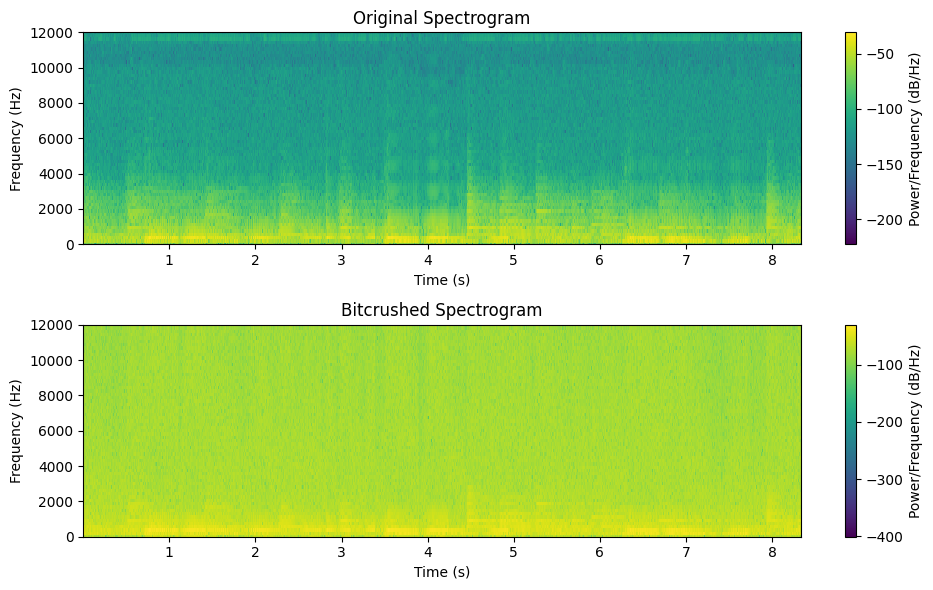

In [17]:
# Compute the spectrogram
frequencies_original, times_original, Sxx_original = signal.spectrogram(data[100000:500000,0], fs)

frequencies_bit, times_bit, Sxx_bit = signal.spectrogram(bitcrush_output[100000:500000,0], fs)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.pcolormesh(times_original, frequencies_original, 10 * np.log10(Sxx_original), shading='auto')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('Original Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0, 12000])

plt.subplot(2, 1, 2)
plt.pcolormesh(times_bit, frequencies_bit, 10 * np.log10(Sxx_bit), shading='auto')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('Bitcrushed Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0, 12000])

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Bitcrushed Wavefile (4 bit)')

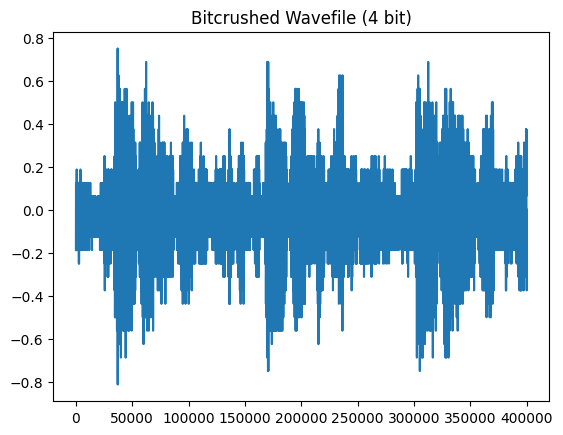

In [18]:
plt.plot(bitcrush_output[100000:500000,0])
plt.title("Bitcrushed Wavefile (4 bit)")